# Wine Reviews | Score Prediction

## Abstract

We are trying to predict the wine score by numeic, categorical, and text features. We will execute  

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

## Results

In [161]:
results = pd.read_csv('data/all_models_compared.csv', index_col = 'Unnamed: 0')
results

,MSE,MAE,R2
expanded_bow_ridge_reg_pred,2.887676,1.328582,0.697399
expanded_bow_linear_reg,2.912889,1.334171,0.694757
bow_linear_reg_score,3.070415,1.373518,0.678249
embedding_pred_score,3.778059,1.527535,0.604095
external_embd_model,4.853125,1.743101,0.491438
gbc_clf_score,6.329152,1.908034,0.336764
baseline_3_score,8.491592,2.363831,0.110161
baseline_2_score,9.037190,2.459464,0.052987
baseline_1_score,9.542911,2.532531,-0.000007
dnn_pred,26.000381,3.887531,-1.724596


## Data loading
Loading the original dataset without duplications.

In [3]:
wine_review = pd.read_csv('data/winemag-data-130k-v2-duplicate_free.csv', index_col = 'Unnamed: 0')
wine_review.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Problem Description
We wish to provide a prediction of the wine review score - **Regression problem**.

## Metrics
We are dealing with a prediction (Regression) problem. Therefore, in this paper, we will use three (3) measure metrics:<br>
Mean score error (**MSE**).<br>
R Square (**R2**).<br>
Mean Absolut Error (**MAE**).

In [4]:
from src.my_fuctions import calc_prediction_quality

## Train and Test Split
Spliting the dataset to Train and Test by 80/20.

In [5]:
train_indexes = wine_review.sample(frac = 0.8).index
test_indexes = wine_review[~wine_review.index.isin(train_indexes)].index
assert wine_review.index.all() == test_indexes.append(train_indexes).all()

In [6]:
train_data = wine_review.loc[train_indexes]
test_data = wine_review.loc[test_indexes]
assert len(wine_review) == len(train_data) + len(test_data)

## 1) Baselines

### 1.1) Baseline 1 | Average
The basic baseline is the Average points.

In [7]:
test_data['baseline_1_predicted_points'] = train_data.points.mean()
baseline_1_score = calc_prediction_quality(test_data, 'points', 'baseline_1_predicted_points')
baseline_1_score

MSE    9.542911
MAE    2.532531
R2    -0.000007
dtype: float64

### 1.2) Baseline 2 | Average by Country

In [8]:
avg_points_by_country = train_data.groupby(['country']).points.mean()
avg_points_by_country.head()

country
Argentina                 86.664430
Armenia                   87.500000
Australia                 88.552256
Austria                   90.151067
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [9]:
test_data['baseline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
baseline_2_score = calc_prediction_quality(test_data, 'points', 'baseline_2_predicted_points')
baseline_2_score

MSE    9.037190
MAE    2.459464
R2     0.052987
dtype: float64

### 1.3) Baseline 3 | Averege by Country and Province

In [10]:
avg_points_by_country_and_province = train_data.groupby(['country', 'province']).points.mean().rename('baseline_3_predicted_points')
test_data_with_bs_3 = test_data.merge(avg_points_by_country_and_province, on = ['country', 'province'], how = 'left')
test_data_with_bs_3.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,baseline_1_predicted_points,baseline_2_predicted_points,baseline_3_predicted_points
0,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,88.440546,88.557541,85.915663
1,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,88.440546,88.582271,88.092549
2,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,88.440546,88.847190,89.333902
3,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte,88.440546,88.582271,88.092549
4,US,"Red fruit aromas pervade on the nose, with cig...",NaN,87,32.0,Virginia,Virginia,NaN,Alexander Peartree,NaN,Quiévremont 2012 Meritage (Virginia),Meritage,Quiévremont,88.440546,88.557541,85.580479


In [11]:
test_data_with_bs_3['baseline_3_predicted_points'] = test_data_with_bs_3.baseline_3_predicted_points.fillna(test_data_with_bs_3.baseline_2_predicted_points)
test_data_with_bs_3[test_data_with_bs_3.baseline_3_predicted_points.isna()].shape

(0, 16)

In [12]:
test_data['baseline_3_predicted_points'] = test_data_with_bs_3.baseline_3_predicted_points

In [13]:
baseline_3_score = calc_prediction_quality(test_data_with_bs_3, 'points', 'baseline_3_predicted_points')
baseline_3_score

MSE    8.491592
MAE    2.363831
R2     0.110161
dtype: float64

### 1.4) Prediction Score summary
For Baseline 1-3.

In [14]:
baseline_summary = pd.DataFrame([baseline_1_score, baseline_2_score, baseline_3_score],
                                index = ['baseline_1', 'baseline_2', 'baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.542911,2.532531,-0.000007
baseline_2,9.037190,2.459464,0.052987
baseline_3,8.491592,2.363831,0.110161


## 2) Training a Boosting Tree

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

### 2.1) Preparing the Data
Label encoding for categorical features.

In [16]:
wine_review.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [17]:
categorial_features = ['country', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'variety', 'winery']
numerical_features = ['price']
features = categorial_features + numerical_features

In [18]:
encoded_features = wine_review[categorial_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_review.price.fillna(-1)
encoded_features['points'] = wine_review.points
encoded_features.head()

,country,designation,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,36806,332,424,6,9,691,11608,-1.0,87
1,32,2325,108,738,6,16,451,12956,15.0,87
2,41,23169,269,1218,17,15,437,13018,14.0,87
3,41,27975,218,549,6,0,480,14390,13.0,87
4,41,36466,269,1218,17,15,441,14621,65.0,87


### 2.2) Train and Test Split

In [19]:
train_encoded = encoded_features.loc[train_indexes]
test_encoded = encoded_features.loc[test_indexes]
assert len(train_encoded) == len(train_data), len(test_encoded) == len(test_data)

In [20]:
train_x_encoded = train_encoded[['country', 'province', 'region_1', 'region_2', 'taster_name', 'variety', 'winery', 'price']]
train_y_encoded = train_encoded['points']
test_x_encoded = test_encoded[['country', 'province', 'region_1', 'region_2', 'taster_name', 'variety', 'winery', 'price']]
test_y_encoded = test_encoded['points']

### 2.3) Fitting Tree Classifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
n_estimators = 80
learning_rate = 0.05
gbc_clf = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators)

In [23]:
gbc_clf.fit(train_x_encoded, train_y_encoded.values)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=80)

In [24]:
test_data['gbc_clf_pred'] = gbc_clf.predict(test_x_encoded)

In [25]:
test_data.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,baseline_1_predicted_points,baseline_2_predicted_points,baseline_3_predicted_points,gbc_clf_pred
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,88.440546,88.557541,88.092549,87
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,88.440546,88.582271,88.092549,87
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,88.440546,88.847190,88.620260,88


In [26]:
gbc_clf_score = calc_prediction_quality(test_data, 'points', 'gbc_clf_pred')
gbc_clf_score

MSE    6.329152
MAE    1.908034
R2     0.336764
dtype: float64

In [27]:
all_compared = pd.DataFrame([baseline_1_score, baseline_2_score, baseline_3_score, gbc_clf_score],
                            index = ['baseline_1_score', 'baseline_2_score', 'baseline_3_score', 'gbc_clf_score'])
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764


In [28]:
all_compared.to_csv('data/all_models_compared.csv', index = True)

## 3) Classical Natural Language Processing (NLP)

### 3.1) Text only
Using only the text from the "description" column.

In [29]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barmizrahi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Classical NLP
**Bag of Words:**

prepering the data:
1) Cleaning the wine descriptions from stopwords, special characters,  and space characters.
1) Building the Vocabulary

In [30]:
stopwords = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('french') + nltk.corpus.stopwords.words('spanish')
specialChars = [",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'"[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…']
space_chars = ['.',',',';', '&', '?','!']
removable_characters = stopwords + specialChars + space_chars

Drop removable characters from the Desription:

In [31]:
wine_review['clean_description'] = wine_review.description.apply(lambda desc: " ".join([token.lower() for token in nltk.word_tokenize(desc) if token.lower() not in removable_characters]))

In [32]:
wine_review[['description', 'clean_description']].sample(5)

,description,clean_description
26361,"This is a smooth and polished wine, with herb ...",smooth polished wine herb new wood aromas juic...
128970,"Velvety smooth, this estate-driven wine is sof...",velvety smooth estate-driven wine soft backbon...
23266,"A blend of Zinfandel and Syrah, this wine is e...",blend zinfandel syrah wine exceptionally ripe ...
49026,Rubbery berry aromas come with a note of raw o...,rubbery berry aromas come note raw oak palate ...
27901,"Chunky, jammy and full of blackberry and boyse...",chunky jammy full blackberry boysenberry aroma...


Building the vocabulary:
First, we are expolring the words frequency in the wine descriptions. Then, we're disscusing the vocabulry size and as its results the words that will be bulit the vocabulry

In [33]:
bow_df_train = wine_review.loc[train_indexes]
bow_df_test = wine_review.loc[test_indexes]
assert bow_df_test.shape[0] + bow_df_train.shape[0] == wine_review.shape[0]

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

Train Bag of Words:

In [35]:
all_train_words = [word for description in bow_df_train.clean_description for word in nltk.word_tokenize(description)]
train_words_df = pd.DataFrame(data = all_train_words, columns = ['words']).words.value_counts().reset_index()
train_words_df.columns = ['words','wordCount']
train_words_df.head()

,words,wordCount
0,wine,59102
1,flavors,46373
2,'s,38216
3,fruit,33192
4,aromas,28966


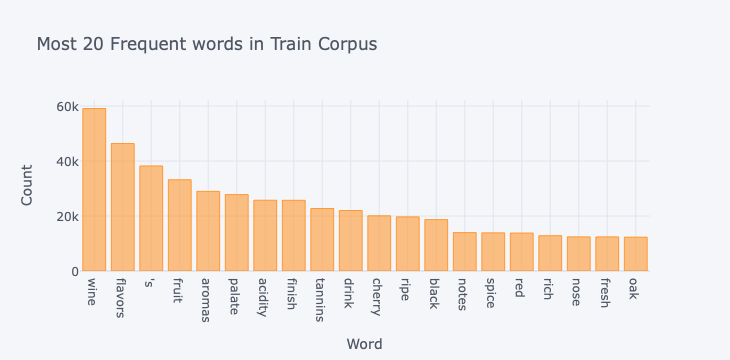

In [36]:
train_words_df.head(20).iplot(x = 'words', y = 'wordCount', kind = 'bar', title = 'Most 20 Frequent words in Train Corpus', yTitle = 'Count', xTitle = 'Word')

In [37]:
print(f"In the train data there are {len(all_train_words)} words in total, and {len(train_words_df)} unique words.")

In the train data there are 2430135 words in total, and 41010 unique words.


In [38]:
l = []
for q in np.arange(0,1,0.05):
    value = train_words_df.wordCount.quantile(q = q)
    vocabulary_size = train_words_df.query(f"wordCount > {value}").shape[0]
    l.append((q, value, vocabulary_size))
pd.DataFrame(l, columns=['q', 'value', 'vocabulary_size']).sort_values(by='value', ascending=False).head(5)

,q,value,vocabulary_size
19,0.95,124.0,2045
18,0.90,36.0,4090
17,0.85,17.0,6089
16,0.80,10.0,7919
15,0.75,6.0,10076


In [39]:
print (f"Using words with 36 or more appearnces will reduce the corpus size to: {sum(train_words_df.wordCount > 36)}.")

Using words with 36 or more appearnces will reduce the corpus size to: 4090.


In [40]:
filt_train_words_df = train_words_df.query(f"wordCount > 36")
filt_train_words_df.shape

(4090, 2)

In [41]:
vocabulary = set(filt_train_words_df.words)
count_vect = CountVectorizer(vocabulary = vocabulary, tokenizer = nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(bow_df_train.clean_description)
train_bow_counts.shape

(95990, 4090)

In [42]:
test_bow_counts = count_vect.fit_transform(bow_df_test.clean_description)
test_bow_counts.shape

(23998, 4090)

**CHECK:**

In [43]:
bow_df_train.iloc[1].clean_description

'dry brittle mouthfeel watery flavors raspberries combine make wine rustic gets basic pinot noir concept silky smoothness acidity across well enough much else'

In [44]:
print(train_bow_counts[1])

  (0, 165)	1
  (0, 168)	1
  (0, 393)	1
  (0, 577)	1
  (0, 831)	1
  (0, 1170)	1
  (0, 1230)	1
  (0, 1262)	1
  (0, 1464)	1
  (0, 1605)	1
  (0, 2159)	1
  (0, 2348)	1
  (0, 2354)	1
  (0, 2424)	1
  (0, 2681)	1
  (0, 2900)	1
  (0, 3090)	1
  (0, 3271)	1
  (0, 3330)	1
  (0, 3950)	1
  (0, 3971)	1
  (0, 4012)	1


In [45]:
rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
print(rev_dict[57])
print(rev_dict[303])
print(rev_dict[389])
print(rev_dict[477])

2021
aromatic
barrels
blended


**Linear Regerssion:**

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [47]:
bow_linear_reg = LinearRegression()
bow_linear_reg.fit(train_bow_counts, train_data.points)

LinearRegression()

In [48]:
test_data['bow_linear_reg_pred'] = bow_linear_reg.predict(test_bow_counts)
bow_linear_reg_score = calc_prediction_quality(test_data, 'points', 'bow_linear_reg_pred').rename('bow_linear_reg_score')
bow_linear_reg_score

MSE    3.070415
MAE    1.373518
R2     0.678249
Name: bow_linear_reg_score, dtype: float64

In [49]:
all_compared = pd.DataFrame([baseline_1_score, baseline_2_score, baseline_3_score, gbc_clf_score, bow_linear_reg_score],
                            index = ['baseline_1_score', 'baseline_2_score', 'baseline_3_score', 'gbc_clf_score', 'bow_linear_reg_score'])
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249


### 3.2) Text and Other Features
Using both the text and the other features.

In [50]:
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler

In [51]:
other_features_train = train_x_encoded
other_features_test = test_x_encoded

In [52]:
scaler = StandardScaler()
other_features_train = scaler.fit_transform(other_features_train)
other_features_test = scaler.fit_transform(other_features_test)
other_features_train.shape, other_features_test.shape

((95990, 8), (23998, 8))

In [53]:
train_features_spares_matrix = coo_matrix(other_features_train)
train_united_features = hstack((train_bow_counts ,train_features_spares_matrix))

**Linear Regression:**

In [54]:
expanded_bow_linear_reg = LinearRegression()
expanded_bow_linear_reg.fit(train_united_features, train_data.points)

LinearRegression()

In [55]:
test_features_spares_matrix = coo_matrix(other_features_test)
test_united_features = hstack((test_bow_counts ,test_features_spares_matrix))

In [56]:
test_data['expanded_bow_linear_reg'] = expanded_bow_linear_reg.predict(test_united_features)
expanded_bow_linear_reg = calc_prediction_quality(test_data,'points', 'expanded_bow_linear_reg').rename('expanded_bow_linear_reg')
expanded_bow_linear_reg

MSE    2.912889
MAE    1.334171
R2     0.694757
Name: expanded_bow_linear_reg, dtype: float64

In [57]:
all_compared = all_compared.append(expanded_bow_linear_reg.to_frame().transpose())
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249
expanded_bow_linear_reg,2.912889,1.334171,0.694757


**Ridge Regression:**
Chek whether Regularization would benefit.

In [58]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [59]:
search_grid = np.logspace(-2, 4, num = 50, endpoint = True, base = 10.0)
r2_by_alpha = []
for alpha in search_grid:
    expanded_bow_ridge_reg = Ridge(alpha = alpha)
    avg_score = cross_val_score(expanded_bow_ridge_reg, X = train_united_features, y = train_data.points, cv = 10, scoring = 'r2').mean()
    r2_by_alpha.append((alpha,avg_score))

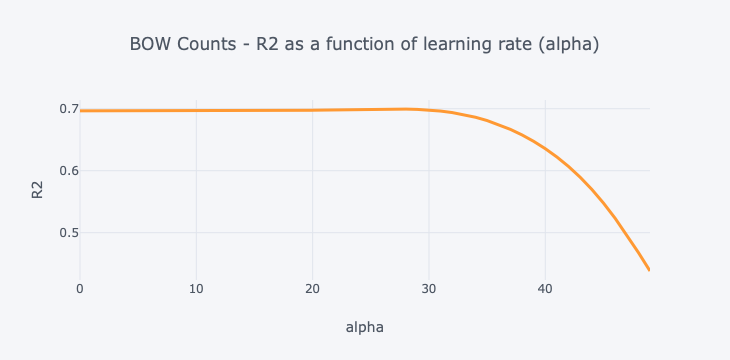

In [60]:
cv_results = pd.DataFrame(r2_by_alpha, columns = ['alpha', 'r2'])
cv_results.r2.iplot(title = 'BOW Counts - R2 as a function of learning rate (alpha)',
                    xTitle = 'alpha',
                    yTitle = 'R2',
                    width = 3,
                    hline = (0,0)
                   )

In [61]:
opt_alpha, opt_r2 = cv_results.loc[cv_results.r2.idxmax()]
opt_alpha, opt_r2

(20.235896477251575, 0.6994891547306358)

In [62]:
expanded_bow_ridge_reg = Ridge(alpha = opt_alpha)
expanded_bow_ridge_reg.fit(train_united_features, train_data.points)

Ridge(alpha=20.235896477251575)

In [63]:
test_data['expanded_bow_ridge_reg_pred'] = expanded_bow_ridge_reg.predict(test_united_features)
expanded_bow_ridge_reg_pred = calc_prediction_quality(test_data, 'points', 'expanded_bow_ridge_reg_pred').rename('expanded_bow_ridge_reg_pred')
expanded_bow_ridge_reg_pred

MSE    2.887676
MAE    1.328582
R2     0.697399
Name: expanded_bow_ridge_reg_pred, dtype: float64

In [64]:
all_compared = all_compared.append(expanded_bow_ridge_reg_pred.to_frame().transpose())
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249
expanded_bow_linear_reg,2.912889,1.334171,0.694757
expanded_bow_ridge_reg_pred,2.887676,1.328582,0.697399


## 4) Deep Learning approaches

### 4.1) Simple NN Prediction

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [127]:
dnn_model = Sequential()
dnn_model.add(Dense(256, input_dim = 8))
dnn_model.add(Activation('relu'))
dnn_model.add(Dense(1))
dnn_model.add(Activation('linear'))

In [128]:
optimizer = Adam(learning_rate = 0.001)

In [129]:
dnn_model.compile(optimizer = optimizer,
                  loss = 'mean_squared_error',
                  metrics = ['mean_squared_error','mean_absolute_error']
                 )

In [130]:
early_stopping_monitor = EarlyStopping(monitor = 'val_loss',
                                       min_delta = 0,
                                       patience = 5,
                                       verbose = 0,
                                       restore_best_weights = True
                                      )

In [131]:
dnn_model.fit(x = train_x_encoded,
              y = train_y_encoded,
              validation_data = (test_x_encoded, test_y_encoded),
              batch_size = 50,
              epochs = 100,
              verbose = True,
              callbacks = [early_stopping_monitor]
             )

Epoch 1/100
1920/1920 [==============================] - 2s 921us/step - loss: 470.9062 - mean_squared_error: 470.9062 - mean_absolute_error: 14.2851 - val_loss: 194.6836 - val_mean_squared_error: 194.6836 - val_mean_absolute_error: 10.7785
Epoch 2/100
1920/1920 [==============================] - 2s 1ms/step - loss: 253.5015 - mean_squared_error: 253.5015 - mean_absolute_error: 12.4231 - val_loss: 166.6944 - val_mean_squared_error: 166.6944 - val_mean_absolute_error: 10.0127
Epoch 3/100
1920/1920 [==============================] - 2s 1ms/step - loss: 205.5007 - mean_squared_error: 205.5007 - mean_absolute_error: 11.2181 - val_loss: 135.3189 - val_mean_squared_error: 135.3189 - val_mean_absolute_error: 8.9836
Epoch 4/100
1920/1920 [==============================] - 2s 871us/step - loss: 181.3310 - mean_squared_error: 181.3310 - mean_absolute_error: 10.5619 - val_loss: 112.5870 - val_mean_squared_error: 112.5870 - val_mean_absolute_error: 8.4009
Epoch 5/100
1920/1920 [===================

In [134]:
test_data['dnn_pred'] = dnn_model.predict(test_x_encoded)

In [135]:
dnn_pred_score = calc_prediction_quality(test_data, 'points', 'dnn_pred').rename('dnn_pred')
dnn_pred_score

MSE    26.000381
MAE     3.887531
R2     -1.724596
Name: dnn_pred, dtype: float64

In [144]:
all_compared = all_compared.append(dnn_pred_score.to_frame().transpose())
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249
expanded_bow_linear_reg,2.912889,1.334171,0.694757
expanded_bow_ridge_reg_pred,2.887676,1.328582,0.697399
dnn_pred,158.636274,10.176998,-15.623592
embedding_pred_score,3.778059,1.527535,0.604095
external_embd_model,4.853125,1.743101,0.491438


### 4.2) Fully connected network on the text only

In [74]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import softmax

In [75]:
wine_review.description.apply(lambda x: len(x.split(' '))).quantile([0.9, 0.95, 0.99])

0.90    55.0
0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [76]:
vocab_size = len(train_words_df)
sequence_length = 72

vectorize_layer = TextVectorization(standardize='lower_and_strip_punctuation',
                                    max_tokens=vocab_size,    
                                    split='whitespace',
                                    output_mode='int',
                                    name = 'Text_processing',
                                    output_sequence_length=sequence_length
                                   )

In [77]:
vectorize_layer.adapt(train_data['description'])

In [78]:
embedding_dim = 30

embedding_model = tf.keras.Sequential([tf.keras.Input(shape = (1,), dtype = tf.string),
                                       vectorize_layer,
                                       Embedding(input_dim = vocab_size, output_dim = embedding_dim, name = "embedding"),
                                       GlobalAveragePooling1D(),
                                       Dense(164, activation = 'relu', name = 'hidden_layer'),
                                       Dropout(0.2),
                                       Dense(1, name = 'output_layer')
                                      ])

In [79]:
embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 30)            1230300   
                                                                 
 global_average_pooling1d (G  (None, 30)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               5084      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [80]:
embedding_model.compile(optimizer = tf.optimizers.Adam(),
                        loss = 'mean_absolute_error',
                        metrics = ['mean_squared_error','mean_absolute_error']
                       )

In [81]:
early_stopping_monitor = EarlyStopping(monitor = 'val_mean_squared_error',
                                       min_delta = 0,
                                       patience = 2,
                                       verbose = 0,
                                       restore_best_weights=True
                                      )

In [82]:
%%time
history = embedding_model.fit(x = bow_df_train['clean_description'],
                              y = train_data['points'],
                              epochs = 20,
                              batch_size = 128,
                              verbose = 1,
                              callbacks = [early_stopping_monitor],
                              validation_data = (bow_df_test['clean_description'], test_data['points'])
                             )

Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 21.9269 - mean_squared_error: 1397.1528 - mean_absolute_error: 21.9269 - val_loss: 2.2298 - val_mean_squared_error: 8.2763 - val_mean_absolute_error: 2.2298
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 4.9562 - mean_squared_error: 38.7248 - mean_absolute_error: 4.9562 - val_loss: 1.9126 - val_mean_squared_error: 5.9624 - val_mean_absolute_error: 1.9126
Epoch 3/20
750/750 [==============================] - 5s 7ms/step - loss: 4.8452 - mean_squared_error: 36.9615 - mean_absolute_error: 4.8452 - val_loss: 1.8046 - val_mean_squared_error: 5.3697 - val_mean_absolute_error: 1.8046
Epoch 4/20
750/750 [==============================] - 5s 7ms/step - loss: 4.7650 - mean_squared_error: 35.8976 - mean_absolute_error: 4.7650 - val_loss: 1.7476 - val_mean_squared_error: 5.0254 - val_mean_absolute_error: 1.7476
Epoch 5/20
750/750 [==============================] - 5s 7ms/step - loss: 4.7508 - mean_

In [83]:
test_data['embedding_prediction'] = embedding_model.predict(bow_df_test['clean_description'])

In [84]:
embedding_pred_score = calc_prediction_quality(test_data, 'points', 'embedding_prediction')
embedding_pred_score

MSE    3.778059
MAE    1.527535
R2     0.604095
dtype: float64

In [85]:
all_compared = all_compared.append(embedding_pred_score.to_frame(name = 'embedding_pred_score').transpose())
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249
expanded_bow_linear_reg,2.912889,1.334171,0.694757
expanded_bow_ridge_reg_pred,2.887676,1.328582,0.697399
dnn_pred,158.636274,10.176998,-15.623592
embedding_pred_score,3.778059,1.527535,0.604095


New running with (1) lower embedding dimention, (2) softamx activation function (the points are between 80 to 100, 21 different values).

In [86]:
# embedding_dim1 = 30

# model_3 = tf.keras.Sequential([
#     tf.keras.Input(shape=(1,), dtype=tf.string),
#     vectorize_layer,
#     Embedding(input_dim = vocab_size, output_dim = embedding_dim, name="embedding"),
#     GlobalAveragePooling1D(),
#     Dense(164, activation ='relu', name='hidden_layer'),
#     Dropout(0.2),
#     Dense(21, activation = 'softmax')
# ])

In [87]:
# model_3.summary()

In [88]:
# model_3.compile(optimizer = tf.optimizers.Adam(),
#               loss='mean_absolute_error',
#               metrics=['mean_squared_error','mean_absolute_error']
#              )

In [89]:
# %%time
# early_stopping_monitor = EarlyStopping(monitor = 'val_mean_squared_error',
#                                        min_delta = 0,
#                                        patience = 2,
#                                        verbose = 0,
#                                        restore_best_weights=True
#                                       )

In [90]:
# %%time
# history_3 = model_3.fit(x = train_data['description'],
#                     y = train_data['points'],
#                     epochs = 20,
#                     batch_size = 128,
#                     verbose = 1,
#                     callbacks = [early_stopping_monitor],
#                     validation_data = (test_data['description'], test_data['points'])
#                    )

In [91]:
# test_data['dnn_3_prediction'] = model_3.predict(test_data['description'])

In [92]:
# dnn_pred_score = calc_prediction_quality(test_data, 'points', 'dnn_3_prediction')
# dnn_pred_score

### Descriptions words concatinated

### 4.3) Using external embedding (description feature only)

In [93]:
import os
import numpy as np

**Load Glove pre-trained word embeddings:**

In [94]:
file = 'data/glove.6B.100d.txt'    
embd_index = {}

In [95]:
with open (file) as f:
    for row in f:
        word, word_vec = row.split(maxsplit = 1)
        word_vec = np.fromstring(word_vec, 'f', sep = ' ')
        embd_index[word] = word_vec

In [96]:
len(embd_index)

400000

In [97]:
vocab = vectorize_layer.get_vocabulary()
vocab_index = dict(zip(vocab, range(len(vocab))))

In [98]:
token_len = len(vocab) + 1
embedding_dim = 100

In [99]:
missing_words = []
embedding_matrix = np.zeros((token_len, embedding_dim))

for token, i in vocab_index.items():
    embedding_vector = embd_index.get(token)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missing_words.append(token)

In [100]:
glove_embed_layer = Embedding(input_dim = token_len,
                              output_dim = embedding_dim,
                              embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                              trainable = False,
                             )

In [101]:
external_embd_model = Sequential([tf.keras.Input(shape = (1, ), dtype = tf.string),
                                  vectorize_layer,
                                  glove_embed_layer,
                                  GlobalAveragePooling1D(),
                                  Dense(164, activation = 'relu', name = 'hidden_layer'),
                                  Dropout(0.2),
                                  Dense(1, name = 'output_layer')
                                  ])

In [102]:
external_embd_model.compile(loss = 'mse',
                            optimizer = tf.optimizers.Adam(learning_rate = 0.001),
                            metrics = ['mean_squared_error', 'mean_absolute_error']
                           )

In [103]:
early_stopping_monitor = EarlyStopping(monitor = 'val_loss',
                                       min_delta = 0,
                                       patience = 3,
                                       verbose = 0,
                                       restore_best_weights=True
                                      )

In [104]:
history = external_embd_model.fit(bow_df_train['clean_description'],
                                  train_data['points'],
                                  epochs = 20,
                                  batch_size = 128,
                                  verbose = 1,  
                                  callbacks = [early_stopping_monitor],
                                  validation_data = (bow_df_test['clean_description'], test_data['points'])
                                 )

Epoch 1/20
750/750 [==============================] - 3s 3ms/step - loss: 1593.3322 - mean_squared_error: 1593.3322 - mean_absolute_error: 29.5338 - val_loss: 273.2693 - val_mean_squared_error: 273.2693 - val_mean_absolute_error: 13.1828
Epoch 2/20
750/750 [==============================] - 2s 3ms/step - loss: 243.8354 - mean_squared_error: 243.8354 - mean_absolute_error: 12.4486 - val_loss: 175.5573 - val_mean_squared_error: 175.5573 - val_mean_absolute_error: 10.5302
Epoch 3/20
750/750 [==============================] - 2s 3ms/step - loss: 146.6405 - mean_squared_error: 146.6405 - mean_absolute_error: 9.5998 - val_loss: 76.2832 - val_mean_squared_error: 76.2832 - val_mean_absolute_error: 6.9296
Epoch 4/20
750/750 [==============================] - 2s 3ms/step - loss: 61.9973 - mean_squared_error: 61.9973 - mean_absolute_error: 6.1772 - val_loss: 16.7309 - val_mean_squared_error: 16.7309 - val_mean_absolute_error: 3.2095
Epoch 5/20
750/750 [==============================] - 2s 3ms/ste

In [105]:
test_data['external_embed_model_pred'] = external_embd_model.predict(bow_df_test['clean_description'])

In [106]:
external_embed_model_pred_score = calc_prediction_quality(test_data, 'points', 'external_embed_model_pred')
external_embed_model_pred_score

MSE    4.853125
MAE    1.743101
R2     0.491438
dtype: float64

In [107]:
all_compared = all_compared.append(external_embed_model_pred_score.to_frame(name = 'external_embd_model').transpose())
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249
expanded_bow_linear_reg,2.912889,1.334171,0.694757
expanded_bow_ridge_reg_pred,2.887676,1.328582,0.697399
dnn_pred,158.636274,10.176998,-15.623592
embedding_pred_score,3.778059,1.527535,0.604095
external_embd_model,4.853125,1.743101,0.491438


### 4.4) LSTM
description feature only

In [108]:
from keras.layers import LSTM, Bidirectional

In [109]:
train_data['clean_description'] = bow_df_train.clean_description
test_data['clean_description'] = bow_df_test.clean_description

In [110]:
lstm_model =  Sequential([tf.keras.Input(shape = (1, ), dtype = tf.string),
                          vectorize_layer,
                          Embedding(input_dim = vocab_size + 1, output_dim = 16, input_length = sequence_length, name = "embedding", mask_zero = True),
                          Bidirectional(LSTM(64)),
                          Dense(164, activation = 'relu', name = 'hidden_layer'),
                          Dense(1, activation = 'linear', name = 'output_layer')
                         ])

In [111]:
optimizer = Adam(learning_rate = 0.001)

lstm_model.compile(optimizer = optimizer,
                   loss = 'mse',
                   metrics = ['mean_squared_error','mean_absolute_error']
                  )

In [112]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 72)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 72, 16)            656176    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 hidden_layer (Dense)        (None, 164)               21156     
                                                                 
 output_layer (Dense)        (None, 1)                 165       
                                                                 
Total params: 718,969
Trainable params: 718,969
Non-tr

In [113]:
lstm_history = lstm_model.fit(x = train_data['clean_description'],
                         y = train_data['points'],
                         epochs = 20,
                         batch_size = 128,
                         verbose = 1,
                         callbacks = [early_stopping_monitor],
                         validation_data = (test_data['clean_description'], test_data['points'])
                        )

Epoch 1/20
750/750 [==============================] - 76s 95ms/step - loss: 311.5043 - mean_squared_error: 311.5043 - mean_absolute_error: 6.6149 - val_loss: 10.6757 - val_mean_squared_error: 10.6757 - val_mean_absolute_error: 2.5355
Epoch 2/20
750/750 [==============================] - 67s 90ms/step - loss: 9.3568 - mean_squared_error: 9.3568 - mean_absolute_error: 2.4361 - val_loss: 8.9626 - val_mean_squared_error: 8.9626 - val_mean_absolute_error: 2.2813
Epoch 3/20
750/750 [==============================] - 67s 90ms/step - loss: 7.3805 - mean_squared_error: 7.3805 - mean_absolute_error: 2.1196 - val_loss: 7.0848 - val_mean_squared_error: 7.0848 - val_mean_absolute_error: 1.9733
Epoch 4/20
750/750 [==============================] - 68s 90ms/step - loss: 4.0644 - mean_squared_error: 4.0644 - mean_absolute_error: 1.5526 - val_loss: 4.2393 - val_mean_squared_error: 4.2393 - val_mean_absolute_error: 1.4870
Epoch 5/20
750/750 [==============================] - 68s 91ms/step - loss: 2.7435

In [136]:
test_data['lstm_pred'] = lstm_model.predict(test_data['clean_description'])

In [137]:
lstm_pred_score = calc_prediction_quality(test_data, 'points', 'lstm_pred')
lstm_pred_score

MSE    3.214080
MAE    1.334126
R2     0.663195
dtype: float64

In [143]:
all_compared.append(lstm_pred_score.to_frame(name = 'lstm').transpose())
all_compared

,MSE,MAE,R2
baseline_1_score,9.542911,2.532531,-0.000007
baseline_2_score,9.037190,2.459464,0.052987
baseline_3_score,8.491592,2.363831,0.110161
gbc_clf_score,6.329152,1.908034,0.336764
bow_linear_reg_score,3.070415,1.373518,0.678249
expanded_bow_linear_reg,2.912889,1.334171,0.694757
expanded_bow_ridge_reg_pred,2.887676,1.328582,0.697399
dnn_pred,158.636274,10.176998,-15.623592
embedding_pred_score,3.778059,1.527535,0.604095
external_embd_model,4.853125,1.743101,0.491438


# 5) Save the results

In [157]:
all_compared.sort_values(by = 'MAE').to_csv('data/all_models_compared.csv', index = True)